## ECE 285 - Final Project
## Training a neural network to predict image category using functional magnetic resonance imaging (fMRI) signals.
###  Instructor: Xiaolong Wang
### Teaching Assistants: Yang Fu, Jiarui Xu, Yinbo Chen
*****************************************************************************************************************
Shayne Wang, A15776202

Bochen Pan, A15562542

ECE MLDS, UCSD, June 2023
******************************************************************************************************************

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random


# Option to use GPU
USE_GPU = True 

dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

Tensor = torch.cuda.FloatTensor if USE_GPU else torch.FloatTensor
np.random.seed(0)

using device: cuda


In [2]:
###################################################################################
#  Section 1: DATA IMPORT
#  We import the dataset in .csv format and convert each into a data frame
#  The dataset has been divided into 4 files. Note that each file has different
#  number of columns.
#  Generate X and Y in tensors from data frame
###################################################################################

def importData(file_name):
    """
    Convert data in a csv file to numpy
    
    Inputs:
    - one of the csv file name for dataset
    
    Returns: 
    - X: 2-D numpy array, float32, [num_samples, num_columns]
    - Y: 1-D numpy array, int, [num_sample]
    - class_dict: a dictionary for the classes in this dataset
    """
    # read in csv file and convert to data frame
    pd_fMRI = pd.read_csv(file_name)

    # display the 5 lines of the data frame
    print('*'*100)
    print(pd_fMRI.head())

    # generate X and Y in numpy
    X = pd_fMRI.values[:,2:-1].astype(float) #.unsqueeze(1) #.unsqueeze(1)
    Y = pd_fMRI.values[:,-1] # numpy array
    
    # filter out the name of categories
    Y_class = set(Y.tolist())
    # create a dictionary for category vs index
    class_dict = dict(zip(Y_class,range(len(Y_class))))

    # convert category Y into integer since PyTorch doesn't have dtype for string
    Y = np.array([class_dict.get(a_class) for a_class in Y.tolist()])
    num_records = [(Y==i).sum() for i in range(len(class_dict))] 
    for i,j,k in zip(list(class_dict.keys()),list(class_dict.values()),num_records):
        print('{}:{} ({})'.format(i,j,k))
    
    print('shape of data: ', X.shape, Y.shape)
    print('*'*100)
    
    return X,Y,class_dict

# read out 4 csv files
X_data_1, Y_data_1, class_dict_1 = importData('df_merged_subject1.csv')
X_data_2, Y_data_2, class_dict_2 = importData('df_merged_subject2.csv')
X_data_3, Y_data_3, class_dict_3 = importData('df_merged_subject3.csv')
X_data_4, Y_data_4, class_dict_4 = importData('df_merged_subject4.csv')

****************************************************************************************************
   subject                         image_id  LHEarlyVis#0  LHEarlyVis#1  \
0        1             n01930112_19568.JPEG      0.167271      1.173377   
1        1             n03733281_29214.JPEG      1.258984      0.744704   
2        1              n07695742_5848.JPEG      0.279666     -0.164892   
3        1  COCO_train2014_000000420713.jpg      0.473376     -0.299339   
4        1  COCO_train2014_000000488558.jpg      0.224416      1.852141   

   LHEarlyVis#2  LHEarlyVis#3  LHEarlyVis#4  LHEarlyVis#5  LHEarlyVis#6  \
0     -0.482830      0.561836      0.487629     -1.366299      0.526726   
1      0.264117     -0.199035      0.221795     -1.114712      0.549931   
2     -0.550474      0.587374      0.319142     -0.022280      1.146169   
3      0.365422      0.443424      0.986940      0.916352      0.656573   
4      1.087473     -0.393302      0.129446      0.858346     -0.352569  

In [2]:
###################################################################################
#  Section 2: DATA PREPROCESSING AND SPLIT
#  Preprocess the data in this section
#  Split the dataset into training:validation:test = 80%:10%:10%. 
###################################################################################

def createLoader(X_data,Y_data,batch_size):
    """
    Generate 3 dataloader for training, val and test sets.
    
    Inputs:
    - X_data,Y_data: tensor, dataset ready for split
    - batch_size: int, number of batch size fed to the model at a time
    
    Returns: 
    - 3 loader respectively for training, val and test sets 
    """
    # Encapsulate as a dataset (X,Y) ready to split
    dataset = TensorDataset(Tensor(X_data), Tensor(Y_data))
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataloader,valid_dataloader,test_dataloader


In [4]:
###################################################################################
#  Section 3: A TRAINING LOOP AND CHECK ACCURACY FUNCTIONS
#  Used to train any SELF-DEFINED MODEL and return accuracy on training set
#  check_accuracy_part34 return accuracy of dataloadfer.
###################################################################################
# use dataloader to feed the model
def train_part34(model, train_dataloader, valid_dataloader, optimizer, epochs=1):
    """
    A training loop
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - train_dataloader, valid_dataloader: the data loaders for training and val sets.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: The accuracy of the model
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_dataloader):
            torch.cuda.empty_cache()
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_part34(valid_dataloader, model, isTestSet=False)
                print()
    return check_accuracy_part34(valid_dataloader, model, isTestSet=False)


def check_accuracy_part34(loader, model, isTestSet=True):
    
    if isTestSet:
        print('Checking accuracy on test set')
    else:
        print('Checking accuracy on validation set') 
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc


# Define a Flatten layer. Use it before FCL if the input tensor is NOT 2-D. 
def flatten(x):
    N = x.shape[0] # read in N, C, H, W, or N,C,W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [5]:
###################################################################################
#  Section 4: Model 1    
#  Define a 2-layer MLP. 
#  This is a baseline
###################################################################################

learning_rate = 1e-3
hidden_layer_size = 256
epochs = 20
batch_size = 64

# Constant to control how frequently we print train loss
print_every = 100

def testModel1(X_data, Y_data, class_dict):
    """
    Define, train and test a MLP model 
    
    Inputs:
    - Tensors and the dictionary for a csv file
    
    Returns: NO return. But it prints out the loss during training process
             and accuracy of val and test set for the model
    """
    # the 4 csv files contain different features and classes
    input_dim = X_data.shape[-1]
    num_class = len(class_dict_1)
    
    train_dataloader, valid_dataloader, test_dataloader = createLoader(X_data,Y_data,batch_size)
    
    model1 = None
    # define and modify the architecture
    model1 = nn.Sequential(
        Flatten(),
        nn.Linear(input_dim, hidden_layer_size),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_layer_size, num_class),
        nn.ReLU(),
        nn.Dropout(0.5),
    )

    optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

    train_part34(model1, train_dataloader, valid_dataloader, optimizer, epochs=epochs)
    check_accuracy_part34(test_dataloader, model1)
    print('*'*60)

#test Model1 upon 4 csv files
print('*'*60)
testModel1(X_data_1, Y_data_1, class_dict_1)
testModel1(X_data_2, Y_data_2, class_dict_2)
testModel1(X_data_3, Y_data_3, class_dict_3)
testModel1(X_data_4, Y_data_4, class_dict_4)

************************************************************
Checking accuracy on validation set
Got 270 / 502 correct (53.78)
Checking accuracy on test set
Got 315 / 504 correct (62.50)
************************************************************
Checking accuracy on validation set
Got 265 / 502 correct (52.79)
Checking accuracy on test set
Got 271 / 504 correct (53.77)
************************************************************
Checking accuracy on validation set
Got 276 / 502 correct (54.98)
Checking accuracy on test set
Got 252 / 504 correct (50.00)
************************************************************
Checking accuracy on validation set
Got 161 / 300 correct (53.67)
Checking accuracy on test set
Got 163 / 302 correct (53.97)
************************************************************


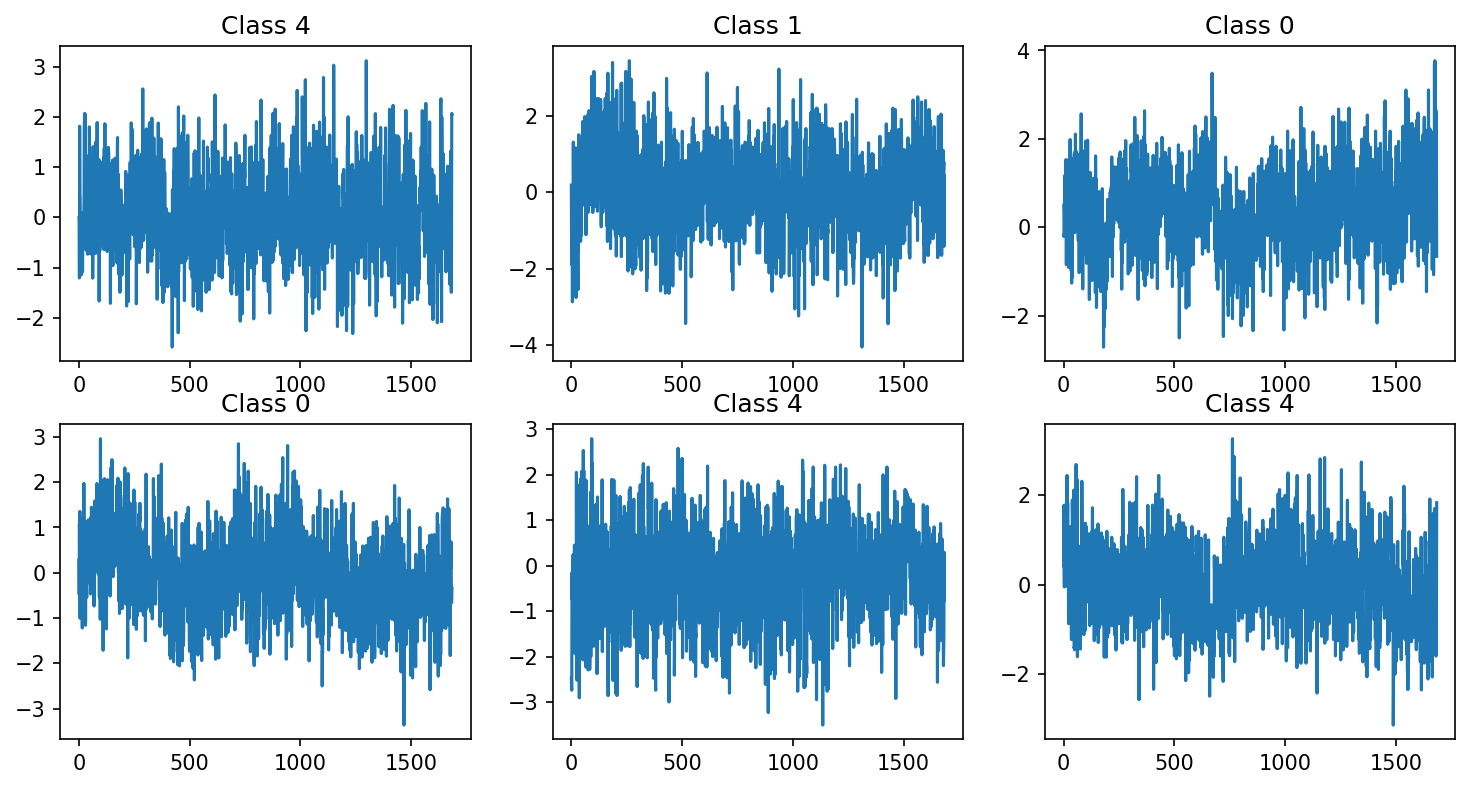

In [6]:
###################################################################################
#  Section 5a: Visualize 6 Records form 1st csv file as Sequences
###################################################################################

from matplotlib import pyplot as plt

x_num = X_data_1.shape[1] 
index = random.sample(range(x_num),6)

fig = plt.figure(figsize=(12,6),dpi=150)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(range(x_num),X_data_1[index[i]])
    plt.title('Class '+str(int(Y_data_1[i])))

plt.show()

In [7]:
###################################################################################
#  Section 5b: Model 2
#  Define a CNN with 2 convolutional layers + 2 FCLs. 
###################################################################################

learning_rate = 1e-3
epochs = 20
batch_size = 64

# Constant to control how frequently we print train loss
print_every = 100

def testModel2(X_data, Y_data, class_dict):
    """
    Define, train and test a MLP model 
    
    Inputs:
    - Tensors and the dictionary for a csv file
    
    Returns: NO return. But it prints out the loss during training process
             and accuracy of val and test set for the model
    """
    # the 4 csv files contain different features and classes
    num_col = X_data.shape[-1]
    num_class = len(class_dict_1)
    kernel_size = 5
    num_pool_size = 2
    hidden_dim =256
    num_conv1 = num_col - kernel_size + 1
    num_pool1 = num_conv1//num_pool_size
    num_conv2 = num_pool1 - kernel_size + 1
    num_pool2 = num_conv2//num_pool_size
    
    # Normalized the input array to N(0,1)
    data_mean =np.mean(X_data)
    data_std = np.std(X_data)
    X_data = (X_data-data_mean)/data_std
    
    train_dataloader, valid_dataloader, test_dataloader = createLoader(X_data,Y_data,batch_size)  

    model2 = None
    # define and modify the architecture
    model2 = nn.Sequential(
        nn.Conv1d(1, 10, kernel_size=kernel_size), #conv1: 1685 =>1661
        nn.ReLU(),
        nn.BatchNorm1d(10),
        nn.AvgPool1d(num_pool_size), # =>415 # pool1
        
        nn.Conv1d(10, 25, kernel_size=kernel_size), # conv2: 415 => 391
        nn.ReLU(),
        nn.BatchNorm1d(25), 
        nn.AvgPool1d(num_pool_size), #pool2  => 97
        nn.Dropout(0.5),
        
        Flatten(),  # N,1,W => N,W
        nn.Linear(num_pool2*25,hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim,num_class),
        nn.ReLU()
    )

    optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

    train_part34(model2, train_dataloader, valid_dataloader, optimizer, epochs=epochs)
    check_accuracy_part34(test_dataloader, model2)
    print('*'*60)

#test Model2 upon 4 csv files
print('*'*60)
# Conv1d requires 3-D input tensor.
testModel2(np.expand_dims(X_data_1,1), Y_data_1, class_dict_1)
testModel2(np.expand_dims(X_data_2,1), Y_data_2, class_dict_2)
testModel2(np.expand_dims(X_data_3,1), Y_data_3, class_dict_3)
testModel2(np.expand_dims(X_data_4,1), Y_data_4, class_dict_4)

************************************************************
Checking accuracy on validation set
Got 268 / 502 correct (53.39)
Checking accuracy on test set
Got 272 / 504 correct (53.97)
************************************************************
Checking accuracy on validation set
Got 224 / 502 correct (44.62)
Checking accuracy on test set
Got 262 / 504 correct (51.98)
************************************************************
Checking accuracy on validation set
Got 266 / 502 correct (52.99)
Checking accuracy on test set
Got 252 / 504 correct (50.00)
************************************************************
Checking accuracy on validation set
Got 164 / 300 correct (54.67)
Checking accuracy on test set
Got 160 / 302 correct (52.98)
************************************************************


In [20]:
###################################################################################
#  RE-MODIFIED 1D CNN MODEL
#  Section 5c: Model 2b
#  we modify it to 4 convolutional layers + 3 FCLs.
###################################################################################

learning_rate = 1e-2
epochs = 20
batch_size = 64

# Constant to control how frequently we print train loss
print_every = 100

def testModel2b(X_data, Y_data, class_dict):
    """
    Define, train and test a MLP model 
    
    Inputs:
    - Tensors and the dictionary for a csv file
    
    Returns: NO return. But it prints out the loss during training process
             and accuracy of val and test set for the model
    """
    # the 4 csv files contain different features and classes
    num_col = X_data.shape[-1]
    num_class = len(class_dict_1)
    kernel_size = 3
    num_pool_size = 2
    
    num_conv1 = (num_col - kernel_size)//2 + 1 # set stride=2 
    num_pool1 = num_conv1//num_pool_size
    num_conv2 = (num_pool1 - kernel_size)//2 + 1
    num_pool2 = num_conv2//num_pool_size
    num_conv3 = (num_pool2 - kernel_size)//2 + 1
    num_pool3 = num_conv3//num_pool_size
    num_conv4 = (num_pool3 - kernel_size)//2 + 1
    num_pool4 = num_conv4//num_pool_size  # output from last conv layer
    
    train_dataloader, valid_dataloader, test_dataloader = createLoader(X_data,Y_data,batch_size)  

    model2b = None
    # define and modify the architecture
    model2b = nn.Sequential(
        nn.Conv1d(1, 16, kernel_size=kernel_size, stride=2), #conv1: 1685 => 841
        nn.ReLU(),
        nn.MaxPool1d(num_pool_size), # =>420 # pool1
        
        nn.Conv1d(16, 32, kernel_size=kernel_size, stride=2), #conv1: 420 => 210
        nn.ReLU(),
        nn.MaxPool1d(num_pool_size),  # pool2: 210 => 105
        
        nn.Conv1d(32, 64, kernel_size=kernel_size, stride=2), #conv1: 105 => 52
        nn.ReLU(),
        nn.MaxPool1d(num_pool_size),  # pool2: 52 => 26
        
        nn.Conv1d(64, 128, kernel_size=kernel_size, stride=2), #conv1: 26 => 12
        nn.ReLU(),
        nn.MaxPool1d(num_pool_size),  # pool2: 12 => 6
        
        Flatten(),  # N,1,W => N,W
        nn.Linear(num_pool4*128,256), # 128 filters
        nn.ReLU(),
        nn.Linear(256,50),
        nn.ReLU(),
        nn.Linear(50,num_class),
        nn.ReLU(),
    )

    optimizer = torch.optim.SGD(model2b.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

    train_part34(model2b, train_dataloader, valid_dataloader, optimizer, epochs=epochs)
    check_accuracy_part34(test_dataloader, model2b)
    print('*'*60)

#test Model2 upon 4 csv files
print('*'*60)
# Conv1d requires 3-D input tensor.
testModel2b(np.expand_dims(X_data_1,1), Y_data_1, class_dict_1)
testModel2b(np.expand_dims(X_data_2,1), Y_data_2, class_dict_2)
testModel2b(np.expand_dims(X_data_3,1), Y_data_3, class_dict_3)
testModel2b(np.expand_dims(X_data_4,1), Y_data_4, class_dict_4)

************************************************************
Checking accuracy on validation set
Got 263 / 502 correct (52.39)
Checking accuracy on test set
Got 279 / 504 correct (55.36)
************************************************************
Checking accuracy on validation set
Got 263 / 502 correct (52.39)
Checking accuracy on test set
Got 256 / 504 correct (50.79)
************************************************************
Checking accuracy on validation set
Got 255 / 502 correct (50.80)
Checking accuracy on test set
Got 262 / 504 correct (51.98)
************************************************************
Checking accuracy on validation set
Got 141 / 300 correct (47.00)
Checking accuracy on test set
Got 164 / 302 correct (54.30)
************************************************************


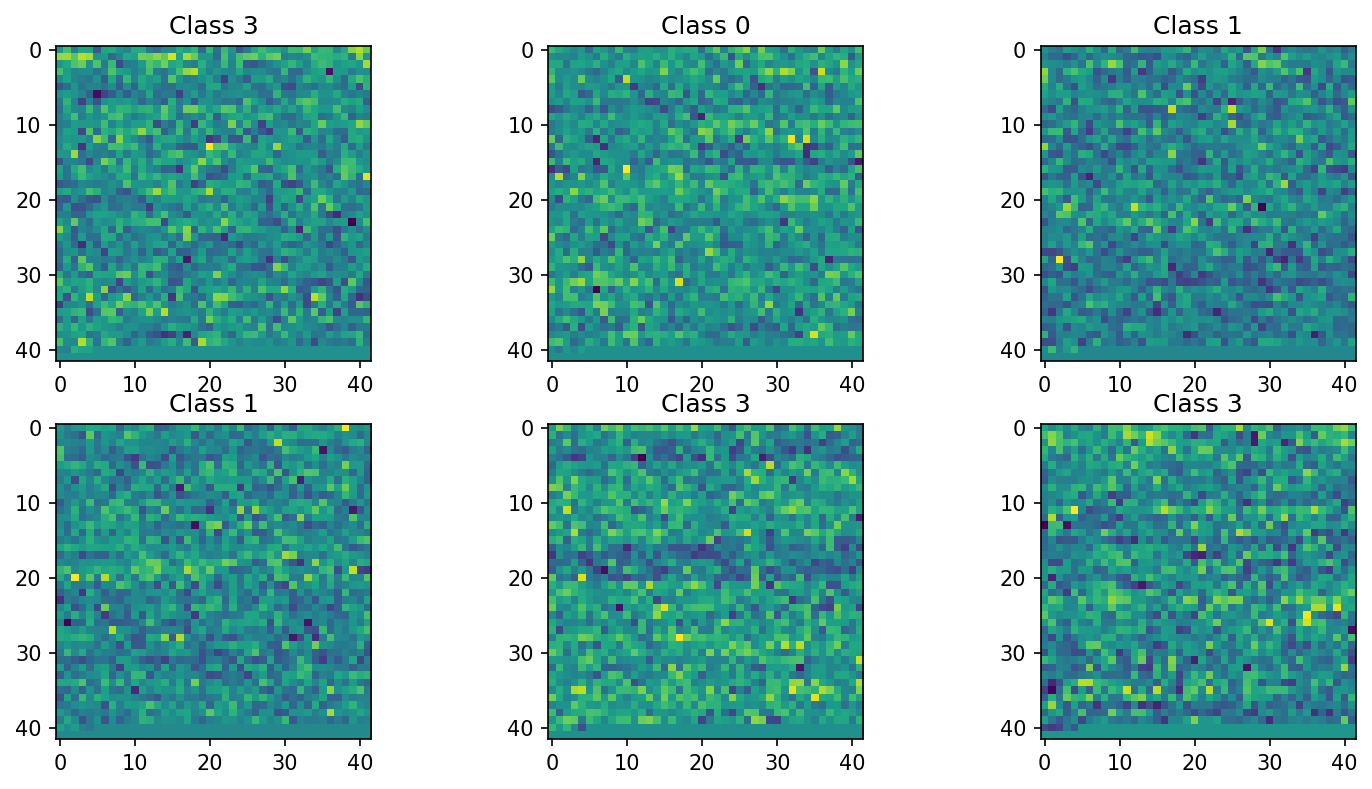

In [5]:
###################################################################################
#  Section 6a: Visualize 6 Records form 1st csv file as Feature Map
###################################################################################
from matplotlib import pyplot as plt

x_num,w = X_data_1.shape

# We consider each record (a vector) as a flattened feature map
# so we perform Min Max Scaling to [0,1]
def minMaxScaling(X):
    X = X.copy()
    minVal, maxVal = np.min(X), np.max(X)
    return (X-minVal)/(maxVal-minVal)

# we reshape 1st-3rd dataset into size of 42*42.
X_data_11 = minMaxScaling(X_data_1)
X_data_11 = np.c_[X_data_1,np.zeros((x_num,42*42-w))]
X_data_11 = X_data_11.reshape(x_num,1,42,42)

index = random.sample(range(x_num),6)

fig = plt.figure(figsize=(12,6),dpi=150)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_data_11[i,:,:,:].reshape(42,42))
    plt.title('Class '+str(int(Y_data_1[i])))

plt.show()

In [6]:
###################################################################################
#  Section 6b: Model 3 - 2D CNN model, VGG-16 
#  also 4 convolutional layers + 3 FCLs.
###################################################################################

learning_rate = 1e-3
epochs = 5
batch_size = 32

# Constant to control how frequently we print train loss
print_every = 999

vgg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
 
class VGG(nn.Module):
    def __init__(self, vgg):
        super(VGG, self).__init__()
        self.features = self._make_layers(vgg)
        self.dense = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )
        self.classifier = nn.Linear(4096, 7)
        
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.dense(out)
        out = self.classifier(out)
        return out
    
    def _make_layers(self, vgg):
        layers = []
        in_channels = 3
        for x in vgg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)       

def testModel3(X_data, Y_data, class_dict):
    """
    Define, train and test a MLP model 
    
    Inputs:
    - Tensors and the dictionary for a csv file
    
    Returns: NO return. But it prints out the loss during training process
             and accuracy of val and test set for the model
    """
    # the 4 csv files contain different features and classes
    num_class = len(class_dict_1)

    train_dataloader, valid_dataloader, test_dataloader = createLoader(X_data,Y_data,batch_size)  

    model3 = VGG(vgg)
    
    #optimizer = torch.optim.AdamW(model3.parameters(), lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-6)
    
    optimizer = torch.optim.SGD(model3.parameters(), lr=learning_rate, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, last_epoch=-1)

    #optimizer = torch.optim.SGD(model3.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

    train_part34(model3, train_dataloader, valid_dataloader, optimizer, epochs=epochs)
    check_accuracy_part34(test_dataloader, model3)
    print('*'*60)

#test Model3-VGG upon 4 csv files
def dataForVGG(X,size):
    """
    Prepare data for VGG model
    MinMax Scaling and convert a vector into a size x size feature map
    """
    X = X.copy()
    x_num,w = X.shape
    X = minMaxScaling(X)
    X = np.c_[X,np.zeros((x_num,size*size-w))] # pad 0
    return X.reshape(x_num,1,size,size).repeat(3,axis=1) # reshape to a square and turn to RGB 3 channels

print('*'*60)
# Conv1d requires 3-D input tensor.
testModel3(dataForVGG(X_data_1,42), Y_data_1, class_dict_1)
testModel3(dataForVGG(X_data_2,42), Y_data_2, class_dict_1)
testModel3(dataForVGG(X_data_3,42), Y_data_3, class_dict_1)
# the 4th dataset has 2787 columns. we reshape it into size of 54*54.
testModel3(dataForVGG(X_data_4,54), Y_data_4, class_dict_4)

************************************************************
Checking accuracy on validation set
Got 259 / 502 correct (51.59)
Checking accuracy on test set
Got 266 / 504 correct (52.78)
************************************************************
Checking accuracy on validation set
Got 256 / 502 correct (51.00)
Checking accuracy on test set
Got 256 / 504 correct (50.79)
************************************************************
Checking accuracy on validation set
Got 266 / 502 correct (52.99)
Checking accuracy on test set
Got 258 / 504 correct (51.19)
************************************************************
Checking accuracy on validation set
Got 156 / 300 correct (52.00)
Checking accuracy on test set
Got 148 / 302 correct (49.01)
************************************************************


In [42]:
###################################################################################
#  Section 7: Model 4 - LSTM model
#  Define a 3-layer stacked LSTM
###################################################################################

learning_rate = 1e-3
epochs = 20
batch_size = 64

seq_len = 128

# Constant to control how frequently we print train loss
print_every = 100

class LSTM_classifier(nn.Module):
    def __init__(self, in_feature=seq_len, hidden_feature=128,num_class=7,num_layers=3,dropout=0.2):
        super(LSTM_classifier, self).__init__()
        self.lstm = nn.LSTM(in_feature,hidden_feature,num_layers=num_layers,dropout=dropout,batch_first=True)
        self.fcl = nn.Linear(hidden_feature,num_class)
        
    def forward(self, x):
        out,_ = self.lstm(x)
        
        out = self.fcl(out[:,-1,:]) # Many-to-One
        return out


def testModel4(X_data, Y_data, class_dict):
    """
    Define, train and test a LSTM model 
    
    Inputs:
    - Tensors and the dictionary for a csv file
    
    Returns: NO return. But it prints out the loss during training process
             and accuracy of val and test set for the model
    """
    # the 4 csv files contain different features and classes
    num_class = len(class_dict_1)

    train_dataloader, valid_dataloader, test_dataloader = createLoader(X_data,Y_data,batch_size)  

    model4 = LSTM_classifier()
    
    #optimizer = torch.optim.AdamW(model3.parameters(), lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-6)
    
    #optimizer = torch.optim.SGD(model4.parameters(), lr=learning_rate, weight_decay=1e-2)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, last_epoch=-1)

    optimizer = torch.optim.SGD(model4.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

    train_part34(model4, train_dataloader, valid_dataloader, optimizer, epochs=epochs)
    check_accuracy_part34(test_dataloader, model4)
    print('*'*60)

#test Model3-VGG upon 4 csv files
def dataForLSTM(X,seq_len):
    """
    Prepare data for LSTM model
    MinMax Scaling and convert a vector
    Split the vector into sequences in length seq_len, where seq_len is also a hyperparameter
    """
    X = X.copy()
    x_num,w = X.shape
    X = minMaxScaling(X)
    num_seq = w//seq_len + 1
    X = np.c_[X,np.zeros((x_num,num_seq*seq_len-w))] # pad 0

    return X.reshape(x_num,num_seq,seq_len) # reshape to [batch,seq,features]

print('*'*60)
testModel4(dataForLSTM(X_data_1,seq_len), Y_data_1, class_dict_1)
testModel4(dataForLSTM(X_data_2,seq_len), Y_data_2, class_dict_2)
testModel4(dataForLSTM(X_data_3,seq_len), Y_data_3, class_dict_3)
testModel4(dataForLSTM(X_data_4,seq_len), Y_data_4, class_dict_4)

************************************************************
Checking accuracy on validation set
Got 233 / 502 correct (46.41)
Checking accuracy on test set
Got 273 / 504 correct (54.17)
************************************************************
Checking accuracy on validation set
Got 248 / 502 correct (49.40)
Checking accuracy on test set
Got 255 / 504 correct (50.60)
************************************************************
Checking accuracy on validation set
Got 250 / 502 correct (49.80)
Checking accuracy on test set
Got 239 / 504 correct (47.42)
************************************************************
Checking accuracy on validation set
Got 156 / 300 correct (52.00)
Checking accuracy on test set
Got 146 / 302 correct (48.34)
************************************************************


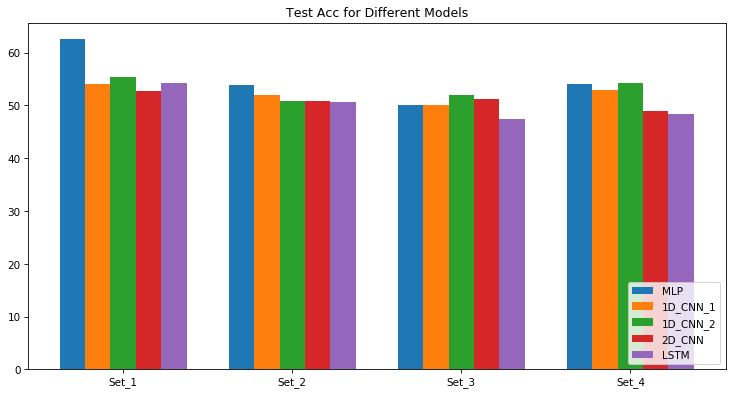

In [3]:
###################################################################################
#  Section 8a: VISUALIZATION 
#  This section is used to visualize the test acc of Model 1 to 5 on dataset 1-4.
#  All data are from experiments abvoe and put into lists manually for plotting.
###################################################################################
result_model1 = [62.50, 53.77, 50.00, 53.97]
result_model2 = [53.97, 51.98, 50.00, 52.98]
result_model2b= [55.36, 50.79, 51.98, 54.30]
result_model3 = [52.78, 50.79, 51.19, 49.01]
result_model4 = [54.17, 50.60, 47.42, 48.34]

labels=['Set_1','Set_2','Set_3','Set_4']
x=np.arange(len(labels))
width=0.15

fig,ax = plt.subplots(figsize=(12,6),dpi=75)
plt.bar(x-width*2,result_model1,width=width, label='MLP') 
ax.bar(x-width,result_model2,width=width,label='1D_CNN_1')
ax.bar(x,result_model2b,width=width,label='1D_CNN_2')
ax.bar(x+width,result_model3,width=width,label='2D_CNN')
ax.bar(x+2*width,result_model4,width=width,label='LSTM')
ax.legend(loc=4)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Test Acc for Different Models')
plt.show()

=====================  end of experiments  =========================

Our report is based on the experiments above. Below cells are for visualization.

In [8]:
###################################################################################
#  Section 8b: RELOAD DATA for VISUALIZATION
#  We re-import the dataset here since the class dictionary might be different.
###################################################################################

def importData(file_name):
    """
    Convert data in a csv file to numpy
    
    Inputs:
    - one of the csv file name for dataset
    
    Returns: 
    - X: 2-D numpy array, float32, [num_samples, num_columns]
    - Y: 1-D numpy array, int, [num_sample]
    - class_dict: a dictionary for the classes in this dataset
    """
    # read in csv file and convert to data frame
    pd_fMRI = pd.read_csv(file_name)

    # display the 5 lines of the data frame
    print('*'*100)
    print(pd_fMRI.head())

    # generate X and Y in numpy
    X = pd_fMRI.values[:,2:-1].astype(float) #.unsqueeze(1) #.unsqueeze(1)
    Y = pd_fMRI.values[:,-1] # numpy array
    
    # filter out the name of categories
    Y_class = set(Y.tolist())
    # create a dictionary for category vs index
    class_dict = dict(zip(Y_class,range(len(Y_class))))

    # convert category Y into integer since PyTorch doesn't have dtype for string
    Y = np.array([class_dict.get(a_class) for a_class in Y.tolist()])
    num_records = [(Y==i).sum() for i in range(len(class_dict))] 
    for i,j,k in zip(list(class_dict.keys()),list(class_dict.values()),num_records):
        print('{}:{} ({})'.format(i,j,k))
    
    print('shape of data: ', X.shape, Y.shape)
    print('*'*100)
    
    return X,Y,class_dict

# read out 4 csv files
X_data_1, Y_data_1, class_dict_1 = importData('.\data\df_merged_subject1.csv')
X_data_2, Y_data_2, class_dict_2 = importData('.\data\df_merged_subject2.csv')
X_data_3, Y_data_3, class_dict_3 = importData('.\data\df_merged_subject3.csv')
X_data_4, Y_data_4, class_dict_4 = importData('.\data\df_merged_subject4.csv')


****************************************************************************************************
   subject                         image_id  LHEarlyVis#0  LHEarlyVis#1  \
0        1             n01930112_19568.JPEG      0.167271      1.173377   
1        1             n03733281_29214.JPEG      1.258984      0.744704   
2        1              n07695742_5848.JPEG      0.279666     -0.164892   
3        1  COCO_train2014_000000420713.jpg      0.473376     -0.299339   
4        1  COCO_train2014_000000488558.jpg      0.224416      1.852141   

   LHEarlyVis#2  LHEarlyVis#3  LHEarlyVis#4  LHEarlyVis#5  LHEarlyVis#6  \
0     -0.482830      0.561836      0.487629     -1.366299      0.526726   
1      0.264117     -0.199035      0.221795     -1.114712      0.549931   
2     -0.550474      0.587374      0.319142     -0.022280      1.146169   
3      0.365422      0.443424      0.986940      0.916352      0.656573   
4      1.087473     -0.393302      0.129446      0.858346     -0.352569  

In [12]:
###################################################################################
#  Section 8b: VISUALIZATION
#  This section is used to visualize the result of Model 1 MLP
#  Generate plots for val acc during training process and heatmap on test acc 
#  We re-import the dataset here since the class dictionary might be different.
###################################################################################

# modify the train function to return val acc
def train_part34_model1(model, train_dataloader, valid_dataloader, optimizer, epochs=1):
    """
    A training loop
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - train_dataloader, valid_dataloader: the data loaders for training and val sets.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: The accuracy of the model on val set
    """
    val_acc = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_dataloader):
            torch.cuda.empty_cache()
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)
                        
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy_part34_model1(valid_dataloader, model, isTestSet=False)
                print()    
        
        # we need to record the val acc
        a_val_acc, _, _ = check_accuracy_part34_model1(valid_dataloader, model, isTestSet=False)
        val_acc.append(a_val_acc)
    return val_acc

def check_accuracy_part34_model1(loader, model, isTestSet=True):
    y_pred, y_true = [],[] 
    if isTestSet:
        print('Checking accuracy on test set')
    else:
        print('Checking accuracy on validation set') 
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
            # record the predicition and true value
            y_pred += list(preds.cpu().numpy())
            y_true += list(y.cpu().numpy())
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc, y_pred, y_true

# Dedine a Flatten layer. Use it before FCL if the input tensor is NOT 2-D. 
def flatten(x):
    N = x.shape[0] # read in N, C, H, W, or N,C,W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
def testModel1_model1(X_data, Y_data, class_dict):
    """
    Define, train and test a MLP model 
    
    Inputs:
    - Tensors and the dictionary for a csv file
    
    Returns: NO return. But it prints out the loss during training process
             and accuracy of val and test set for the model
    """
    # the 4 csv files contain different features and classes
    input_dim = X_data.shape[-1]
    num_class = len(class_dict_1)
    
    train_dataloader, valid_dataloader, test_dataloader = createLoader(X_data,Y_data,batch_size)
    
    # Statics on the number of samples for each class in training and test set
    y_train_true, y_test_true = [], []
    for _, (_, y) in enumerate(train_dataloader):
        y_train_true += list(y.cpu().numpy())
    num_train_records = [(np.array(y_train_true)==i).sum() for i in range(len(class_dict))] 
    
    for _, (_, y) in enumerate(test_dataloader):
        y_test_true += list(y.cpu().numpy())
    num_test_records = [(np.array(y_test_true)==i).sum() for i in range(len(class_dict))] 
    
    model1 = None
    # define and modify the architecture
    model1 = nn.Sequential(
        Flatten(),
        nn.Linear(input_dim, hidden_layer_size),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_layer_size, num_class),
        nn.ReLU(),
        nn.Dropout(0.5),
    )

    optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

    val_acc = train_part34_model1(model1, train_dataloader, valid_dataloader, optimizer, epochs=epochs)
    _, y_pred, y_true = check_accuracy_part34_model1(test_dataloader, model1)
    print('*'*60)
    return val_acc, y_pred, y_true, num_train_records, num_test_records

### train, test and plot
learning_rate = 1e-3
hidden_layer_size = 256
epochs = 20
batch_size = 64

# Constant to control how frequently we print train loss
print_every = 100

#test Model1 upon 4 csv files
print('*'*60)
val_acc_1, y_pred_1, y_true_1, num_train_records_1, num_test_records_1 \
                = testModel1_model1(X_data_1, Y_data_1, class_dict_1)
val_acc_2, y_pred_2, y_true_2, num_train_records_2, num_test_records_2 \
                = testModel1_model1(X_data_2, Y_data_2, class_dict_2)
val_acc_3, y_pred_3, y_true_3, num_train_records_3, num_test_records_3 \
                = testModel1_model1(X_data_3, Y_data_3, class_dict_3)
val_acc_4, y_pred_4, y_true_4, num_train_records_4, num_test_records_4 \
                = testModel1_model1(X_data_4, Y_data_4, class_dict_4)

************************************************************
Checking accuracy on validation set
Got 262 / 502 correct (52.19)
Checking accuracy on validation set
Got 269 / 502 correct (53.59)
Checking accuracy on validation set
Got 275 / 502 correct (54.78)
Checking accuracy on validation set
Got 282 / 502 correct (56.18)
Checking accuracy on validation set
Got 286 / 502 correct (56.97)
Checking accuracy on validation set
Got 282 / 502 correct (56.18)
Checking accuracy on validation set
Got 280 / 502 correct (55.78)
Checking accuracy on validation set
Got 291 / 502 correct (57.97)
Checking accuracy on validation set
Got 285 / 502 correct (56.77)
Checking accuracy on validation set
Got 284 / 502 correct (56.57)
Checking accuracy on validation set
Got 286 / 502 correct (56.97)
Checking accuracy on validation set
Got 288 / 502 correct (57.37)
Checking accuracy on validation set
Got 284 / 502 correct (56.57)
Checking accuracy on validation set
Got 284 / 502 correct (56.57)
Checking accura

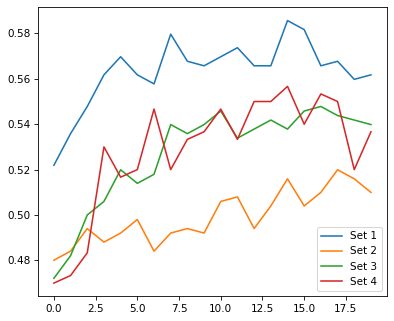

In [13]:
###################################################################################
#  Section 8c: VISUALIZATION - Val Acc
###################################################################################
fig = plt.figure(figsize=(6,5),dpi=75)
plt.plot(range(len(val_acc_1)),val_acc_1,label='Set 1') 
plt.plot(range(len(val_acc_2)),val_acc_2,label='Set 2')
plt.plot(range(len(val_acc_3)),val_acc_3,label='Set 3')
plt.plot(range(len(val_acc_4)),val_acc_4,label='Set 4')
plt.legend(loc=4)
plt.show()

************************************************************
*** Confusion Matrix ***
 [[  0   5   0   0   1   0   0]
 [  0 196   0   0  26  18   0]
 [  0   5   0   0   0   3   0]
 [  0   6   0   0   0   2   0]
 [  0  85   0   0  32  13   0]
 [  0  37   0   0   4  60   0]
 [  0   8   0   0   1   2   0]]
*** Truth Distribution (# of test / # of train***)
0:event (6 / 20)
1:artifact (240 / 2019)
2:plant (8 / 85)
3:person (8 / 71)
4:entity (130 / 898)
5:animal (101 / 807)
6:food (11 / 123)
Total: (504 / 4023)


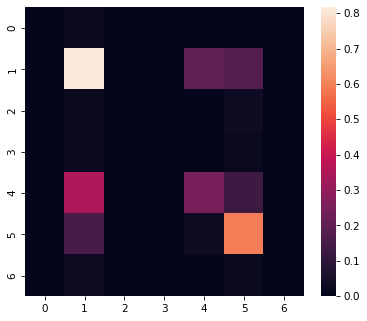

************************************************************
*** Confusion Matrix ***
 [[  0   2   0   0   0   0   0]
 [  0 200   0   0  26  19   0]
 [  0  11   0   0   1   2   0]
 [  0  11   0   0   1   2   0]
 [  0  85   0   0  21   8   0]
 [  0  46   0   0   6  50   0]
 [  0  10   0   0   1   2   0]]
*** Truth Distribution (# of test / # of train***)
0:event (2 / 25)
1:artifact (245 / 2020)
2:person (14 / 74)
3:plant (14 / 79)
4:entity (114 / 894)
5:animal (102 / 818)
6:food (13 / 113)
Total: (504 / 4023)


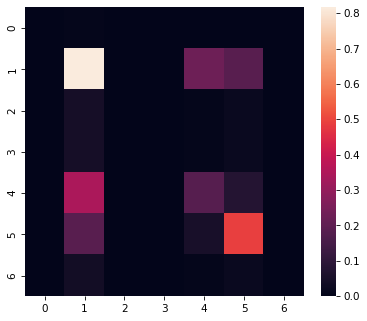

************************************************************
*** Confusion Matrix ***
 [[  0   3   0   0   0   0   0]
 [  0 184   0   0  25  39   0]
 [  0   4   0   0   1   1   0]
 [  0   8   0   0   1   4   0]
 [  0  89   0   0  29  14   0]
 [  0  42   0   0   6  47   0]
 [  0   7   0   0   0   0   0]]
*** Truth Distribution (# of test / # of train***)
0:event (3 / 22)
1:artifact (248 / 2022)
2:plant (6 / 89)
3:person (13 / 76)
4:entity (132 / 872)
5:animal (95 / 822)
6:food (7 / 120)
Total: (504 / 4023)


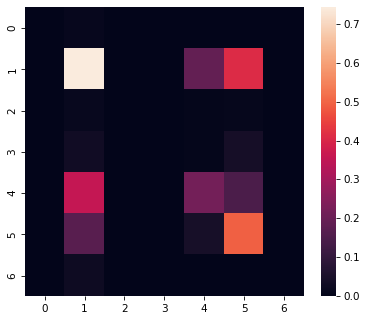

************************************************************
*** Confusion Matrix ***
 [[  0   1   0   0   0   0   0]
 [  0 116   0   0  25  17   0]
 [  0   5   0   0   0   0   0]
 [  0   4   0   0   1   0   0]
 [  0  32   0   0  22   6   0]
 [  0  30   0   0   3  34   0]
 [  0   4   0   0   2   0   0]]
*** Truth Distribution (# of test / # of train***)
0:event (1 / 13)
1:artifact (158 / 1185)
2:plant (5 / 59)
3:person (5 / 49)
4:entity (60 / 564)
5:animal (67 / 466)
6:food (6 / 69)
Total: (302 / 2405)


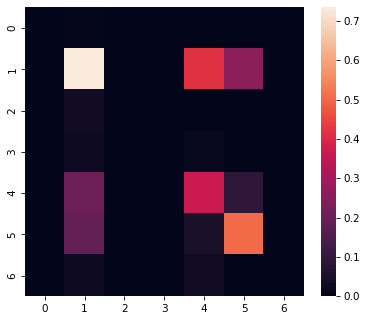

In [14]:
###################################################################################
#  Section 8d: VISUALIZATION - Heatmap for 4 datasets
###################################################################################

from sklearn.metrics import confusion_matrix
from seaborn import heatmap

def plotHeatMap(y_pred, y_true, num_train_records, num_test_records, class_dict):
    print('*'*60)
    C=confusion_matrix(y_true, y_pred)
    print('*** Confusion Matrix ***\n',C)
    
    print('*** Truth Distribution (# of test / # of train***)')
    
    for i,j,k,t in zip(list(class_dict.values()),list(class_dict.keys()),num_test_records,num_train_records):
        print('{}:{} ({} / {})'.format(i,j,k,t))
    
    print('Total: ({} / {})'.format(C.sum(),np.array(num_train_records).sum()))

    fig = plt.figure(figsize=(6,5),dpi=75)
    """
    we define a heatmap as:
        num of records/number of truth of this class, so the diagonal entity
        represents the recall rate for each class
        i.e, each row sums up to 1.0
    """
    heatmap(C/C.sum(axis=1))
    plt.show()

plotHeatMap(y_pred_1,y_true_1,num_train_records_1,num_test_records_1,class_dict_1)
plotHeatMap(y_pred_2,y_true_2,num_train_records_2,num_test_records_2,class_dict_2)
plotHeatMap(y_pred_3,y_true_3,num_train_records_3,num_test_records_3,class_dict_3)
plotHeatMap(y_pred_4,y_true_4,num_train_records_4,num_test_records_4,class_dict_4)